In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import random

from os import path
from keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from keras import layers, losses, optimizers, metrics, callbacks

In [2]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
SEED = 123
N_CLASS = 10
IMG_SIZE = 32

In [4]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
train_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'train.csv')).drop(["Unnamed: 0"], axis=1)
train_labels_df

,name,codes
0,1.png,6
1,100.png,1
2,10001.png,1
3,10002.png,6
4,10003.png,6
...,...,...
34995,9994.png,1
34996,9996.png,3
34997,9997.png,9
34998,9998.png,1


In [6]:
dataset_train = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'train'),
    labels=list(train_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_train = dataset_train.map(lambda x, y : (x, tf.one_hot(y, N_CLASS)))

Found 35000 files belonging to 1 classes.


In [7]:
val_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'val.csv')).drop(["Unnamed: 0"], axis=1)
val_labels_df

,name,codes
0,10.png,3
1,1000.png,5
2,10000.png,5
3,10014.png,6
4,10029.png,7
...,...,...
4995,9961.png,8
4996,9977.png,3
4997,998.png,1
4998,9986.png,0


In [8]:
dataset_val = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'val'),
    labels=list(val_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_val = dataset_val.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 5000 files belonging to 1 classes.


In [9]:
test_labels_df = pd.read_csv(path.join(os.getcwd(), 'train_val_test', 'test.csv')).drop(["Unnamed: 0"], axis=1)

dataset_test = image_dataset_from_directory(
    directory=path.join(os.getcwd(), 'train_val_test', 'test'),
    labels=list(test_labels_df['codes']),
    label_mode='int',
    validation_split=0,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=512,
    seed=SEED
)
dataset_test = dataset_test.map(lambda x, y: (x, tf.one_hot(y, N_CLASS)))

Found 10000 files belonging to 1 classes.


In [10]:
X, y = next(iter(dataset_train))
X.shape, y.shape

(TensorShape([512, 32, 32, 3]), TensorShape([512, 10]))

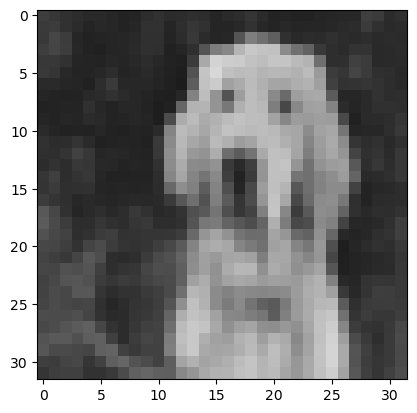

In [11]:
plt.imshow(X[3].numpy().astype(int))

In [12]:
y[3]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

## Simple keras sequential model

In [13]:
def create_model():
    model = keras.Sequential()

    model.add(keras.Input(shape=(32, 32, 3)))

    model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.Conv2D(32, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.Conv2D(64, 3, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(layers.MaxPooling2D(2))

    # Fully connected classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(N_CLASS, activation="softmax"))
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [14]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
)
checkpoint = callbacks.ModelCheckpoint(
    filepath="simple_cnn.h5",
    monitor="val_categorical_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

In [15]:
history = model.fit(
    dataset_train,
    epochs=200,
    validation_data=dataset_val,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/200
69/69 [==============================] - 13s 78ms/step - loss: 2.7701 - categorical_accuracy: 0.3127 - categorical_crossentropy: 2.7701 - val_loss: 1.4448 - val_categorical_accuracy: 0.4872 - val_categorical_crossentropy: 1.4448 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 7s 94ms/step - loss: 1.3794 - categorical_accuracy: 0.5103 - categorical_crossentropy: 1.3794 - val_loss: 1.3818 - val_categorical_accuracy: 0.5112 - val_categorical_crossentropy: 1.3818 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 7s 92ms/step - loss: 1.2064 - categorical_accuracy: 0.5763 - categorical_crossentropy: 1.2064 - val_loss: 1.2548 - val_categorical_accuracy: 0.5642 - val_categorical_crossentropy: 1.2548 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 7s 93ms/step - loss: 1.0843 - categorical_accuracy: 0.6222 - categorical_crossentropy: 1.0843 - val_loss: 1.1811 - val_categorical_accuracy: 0.5854 - val_categorical_crossentropy: 1.1811 

## Experiments

Training will be repeated 10 times with different weights initialization.

In [16]:
TRAINING_SEEDS = list(range(10))
results = []
for seed in TRAINING_SEEDS:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = create_model()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=[metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy()]
    )

    history = model.fit(
        dataset_train,
        epochs=200,
        validation_data=dataset_val,
        shuffle=True,
        callbacks=[early_stopping, reduce_lr]
    )
    eval_results = model.evaluate(dataset_test)

    results += [{
        'seed': seed,
        'results': dict(zip(model.metrics_names, eval_results))
    }]

results = pd.DataFrame(results)
results = pd.concat([results.drop(["results"], axis=1), results["results"].apply(pd.Series)], axis=1)
results.to_csv('simple_cnn_results.csv')

Epoch 1/200
69/69 [==============================] - 8s 103ms/step - loss: 2.9519 - categorical_accuracy: 0.2417 - categorical_crossentropy: 2.9519 - val_loss: 1.7723 - val_categorical_accuracy: 0.3778 - val_categorical_crossentropy: 1.7723 - lr: 0.0010
Epoch 2/200
69/69 [==============================] - 7s 97ms/step - loss: 1.5555 - categorical_accuracy: 0.4387 - categorical_crossentropy: 1.5555 - val_loss: 1.4452 - val_categorical_accuracy: 0.4820 - val_categorical_crossentropy: 1.4452 - lr: 0.0010
Epoch 3/200
69/69 [==============================] - 7s 95ms/step - loss: 1.4033 - categorical_accuracy: 0.4957 - categorical_crossentropy: 1.4033 - val_loss: 1.3764 - val_categorical_accuracy: 0.5144 - val_categorical_crossentropy: 1.3764 - lr: 0.0010
Epoch 4/200
69/69 [==============================] - 7s 97ms/step - loss: 1.2680 - categorical_accuracy: 0.5517 - categorical_crossentropy: 1.2680 - val_loss: 1.2543 - val_categorical_accuracy: 0.5566 - val_categorical_crossentropy: 1.2543 

In [17]:
results

,seed,loss,categorical_accuracy,categorical_crossentropy
0,0,1.567475,0.6311,1.567475
1,1,1.176700,0.6260,1.176700
2,2,2.466713,0.6427,2.466713
3,3,2.215903,0.6500,2.215903
4,4,1.958466,0.6693,1.958466
5,5,3.642200,0.6271,3.642200
6,6,2.624820,0.6556,2.624820
7,7,2.725328,0.6467,2.725328
8,8,1.770065,0.6318,1.770065
9,9,3.348890,0.6360,3.348890
